In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
#import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
import keras
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# load dataset and clean it 

subjects=pd.read_csv("subjects.csv")
subjects=subjects[subjects['Label (0 for the null class)']!=0]
subjects.reset_index(inplace=True)
subjects.drop(columns=['level_0','Unnamed: 0','index'],inplace=True)

In [3]:
# split the train and test dataset based on subject ID to avoid data leakeage
df_train=subjects[(subjects['subject_number']!=10)].drop(columns=['subject_number','electrocardiogram signal (lead 1)','electrocardiogram signal (lead 2)'])

df_test=subjects[(subjects['subject_number']==10)].drop(columns=['subject_number','electrocardiogram signal (lead 1)','electrocardiogram signal (lead 2)'])

In [4]:
# then normalize the data
pd.options.mode.chained_assignment = None  # default='warn'

for i in range(0,21):
    df_train[df_train.columns[i]] = df_train[df_train.columns[i]] / df_train[df_train.columns[i]].max()

In [5]:
# then normalize the data
for i in range(0,21):
    df_test[df_test.columns[i]] = df_test[df_test.columns[i]] / df_test[df_test.columns[i]].max()

In [6]:
# reshape the 1D data into a 3D one
# based on time_period (100) and number of features (21 here as it has 21 sensors)
# create overlap within data. Reason:There is some risk that the splitting of the stream of sensor data into windows
# may result in windows that miss the transition of one activity to another. 

TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 2

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 21
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs1 = df['acceleration from the chest sensor (X axis)'].values[i: i + time_steps]
        ys1 = df['acceleration from the chest sensor (Y axis)'].values[i: i + time_steps]
        zs1 = df['acceleration from the chest sensor (Z axis)'].values[i: i + time_steps]
        xs2 = df['acceleration from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys2 = df['acceleration from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs2 = df['acceleration from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs3 = df['gyro from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys3 = df['gyro from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs3 = df['gyro from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs4 = df['magnetometer from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys4 = df['magnetometer from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs4 = df['magnetometer from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs5 = df['acceleration from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys5 = df['acceleration from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs5 = df['acceleration from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]        
        xs6 = df['gyro from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys6 = df['gyro from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs6 = df['gyro from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]        
        xs7 = df['magnetometer from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys7 = df['magnetometer from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs7 = df['magnetometer from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]            
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs1, ys1, zs1, xs2, ys2, zs2, xs3, ys3, zs3, xs4, ys4, zs4, xs5, ys5, zs5, xs6, ys6, zs6, xs7, ys7, zs7])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              "Label (0 for the null class)")

In [7]:
# reshape the test dataset
# change the data type to float
# perform one-hot-encoding of y_test
x_test, y_test = create_segments_and_labels(df_test,
                                              100,
                                              2,
                                              "Label (0 for the null class)")
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
input_shape = (100*21)
x_test = x_test.reshape(x_test.shape[0], input_shape)

y_test_hot = np_utils.to_categorical(y_test, 13)
print('New y_test shape: ', y_test_hot.shape)
y_test_hot = y_test_hot[:,1:]
print('New y_test shape: ', y_test_hot.shape)

New y_test shape:  (16795, 13)
New y_test shape:  (16795, 12)


In [8]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (154703, 100, 21)
154703 training samples
y_train shape:  (154703,)


In [9]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = 12

In [10]:
# reshape the train dataset

input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (154703, 2100)
input_shape: 2100


In [11]:
# change the data type to float
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [12]:
# perform one-hot-encoding of y_test
y_train_hot = np_utils.to_categorical(y_train, 13)
print('New y_train shape: ', y_train_hot.shape)
y_train_hot = y_train_hot[:,1:]
print('New y_train shape: ', y_train_hot.shape)



New y_train shape:  (154703, 13)
New y_train shape:  (154703, 12)


In [49]:
# create the model
model_basic = Sequential()

model_basic.add(Reshape((100, 21), input_shape=(2100,)))
model_basic.add(Dense(200, activation='relu'))
model_basic.add(Dense(100, activation='relu'))
model_basic.add(Dense(100, activation='relu'))
model_basic.add(Dense(30, activation='relu'))


model_basic.add(Flatten())
model_basic.add(Dense(num_classes, activation='softmax'))



In [52]:
model_basic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 100, 21)           0         
_________________________________________________________________
dense_51 (Dense)             (None, 100, 200)          4400      
_________________________________________________________________
dense_52 (Dense)             (None, 100, 100)          20100     
_________________________________________________________________
dense_53 (Dense)             (None, 100, 100)          10100     
_________________________________________________________________
dense_54 (Dense)             (None, 100, 30)           3030      
_________________________________________________________________
flatten_9 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 12)                36012     
Total para

In [53]:
# compile and fit the model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_basic.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
BATCH_SIZE = 100
EPOCHS = 3

# model_m.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'Adam', metrics = ['accuracy'])
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_basic.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 123762 samples, validate on 30941 samples
Epoch 1/3
123762/123762 [==============================] - 101s 818us/step - loss: 0.0054 - acc: 0.9985 - val_loss: 0.1443 - val_acc: 0.9517
Epoch 2/3
123762/123762 [==============================] - 87s 700us/step - loss: 0.0046 - acc: 0.9986 - val_loss: 0.3160 - val_acc: 0.9035
Epoch 3/3
123762/123762 [==============================] - 81s 653us/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.2539 - val_acc: 0.9325


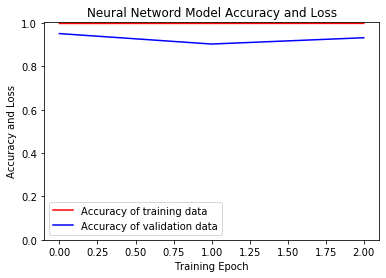

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     13805
         2.0       0.99      1.00      0.99     13824
         3.0       1.00      1.00      1.00     13824
         4.0       0.97      1.00      0.99     13824
         5.0       0.92      0.97      0.94     13799
         6.0       1.00      1.00      1.00     12929
         7.0       1.00      1.00      1.00     13336
         8.0       0.98      0.91      0.94     13236
         9.0       1.00      0.97      0.99     13824
        10.0       1.00      1.00      1.00     13824
        11.0       1.00      1.00      1.00     13824
        12.0       0.99      1.00      1.00      4654

    accuracy                           0.99    154703
   macro avg       0.99      0.99      0.99    154703
weighted avg       0.99      0.99      0.99    154703

[[13791     3     0     0     1     0     0     1     1     0     0     8]
 [    3 13765    21     4    19     0    12     0     0   

In [54]:
# get the evaluation plot for both train and validation dataset
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.title('Neural Netword Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_basic.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)+1
class_report = classification_report(y_train, max_y_pred_train)
conf_mat = confusion_matrix(y_train, max_y_pred_train)
print(class_report)
print(conf_mat)

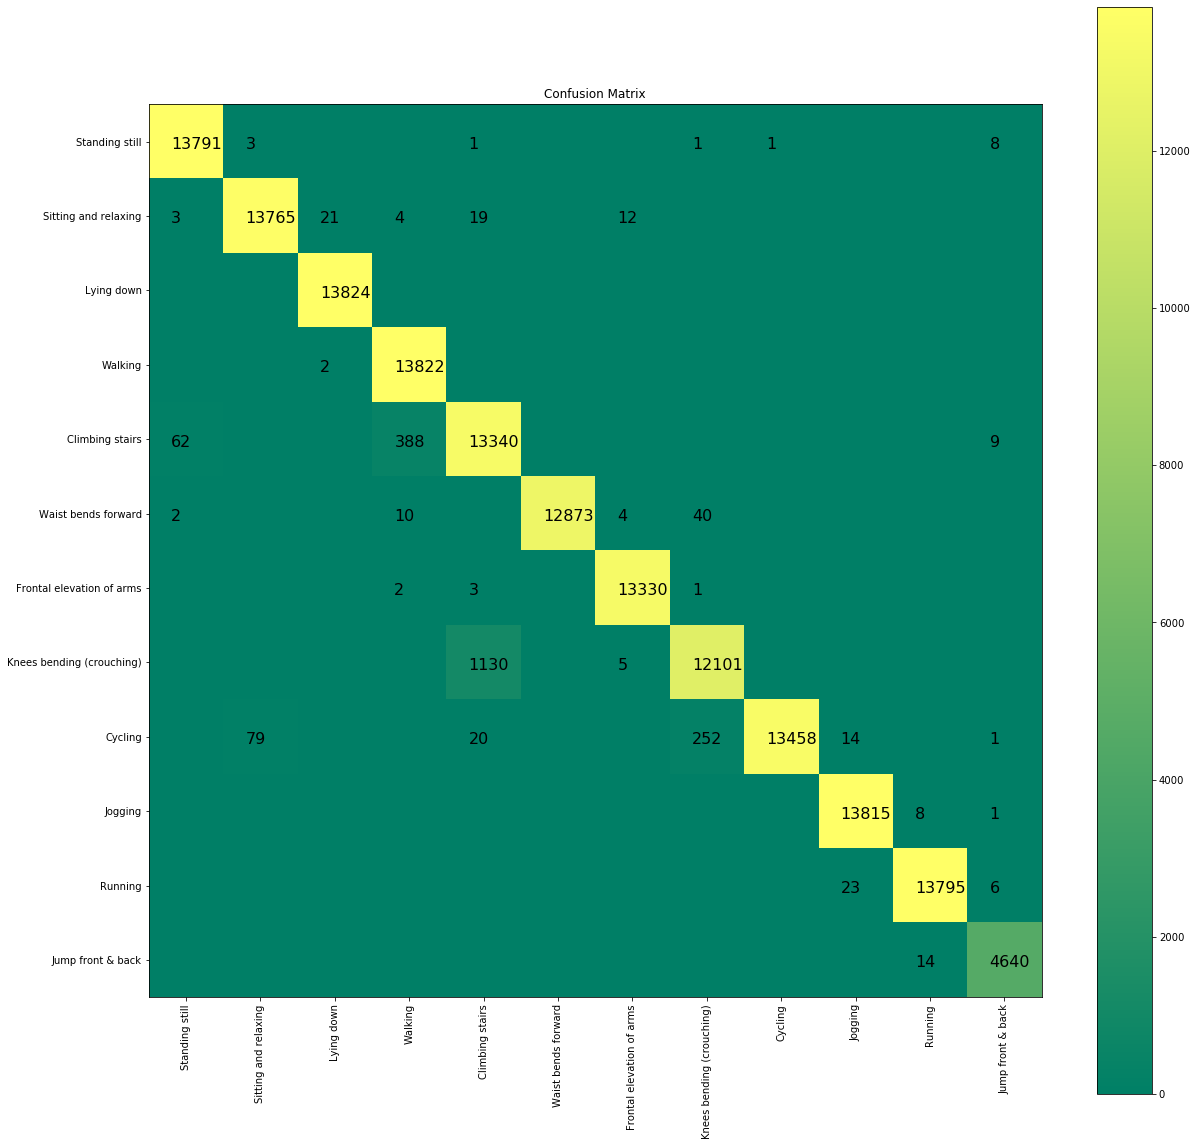

In [55]:
labels =['Standing still','Sitting and relaxing','Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
         'Cycling', 'Jogging', 'Running', 'Jump front & back']

fig = plt.figure(figsize=(20,20))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(12), [l for l in labels], rotation=90)
_ = plt.yticks(range(12), [l for l in labels])

In [56]:
y_pred_test = model_basic.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)+1
class_report_test = classification_report(y_test, max_y_pred_test)
conf_mat_test = confusion_matrix(y_test, max_y_pred_test)
print(class_report_test)
print(conf_mat_test)

              precision    recall  f1-score   support

         1.0       1.00      0.97      0.98      1537
         2.0       1.00      1.00      1.00      1536
         3.0       1.00      1.00      1.00      1536
         4.0       1.00      0.99      0.99      1536
         5.0       1.00      0.81      0.89      1511
         6.0       0.49      1.00      0.66      1229
         7.0       1.00      0.99      1.00      1382
         8.0       0.46      0.17      0.25      1434
         9.0       1.00      1.00      1.00      1536
        10.0       1.00      0.49      0.66      1536
        11.0       0.76      1.00      0.86      1536
        12.0       0.60      1.00      0.75       486

    accuracy                           0.86     16795
   macro avg       0.86      0.87      0.84     16795
weighted avg       0.88      0.86      0.85     16795

[[1485    0    0    0    0   49    0    3    0    0    0    0]
 [   0 1536    0    0    0    0    0    0    0    0    0    0]
 [   0 

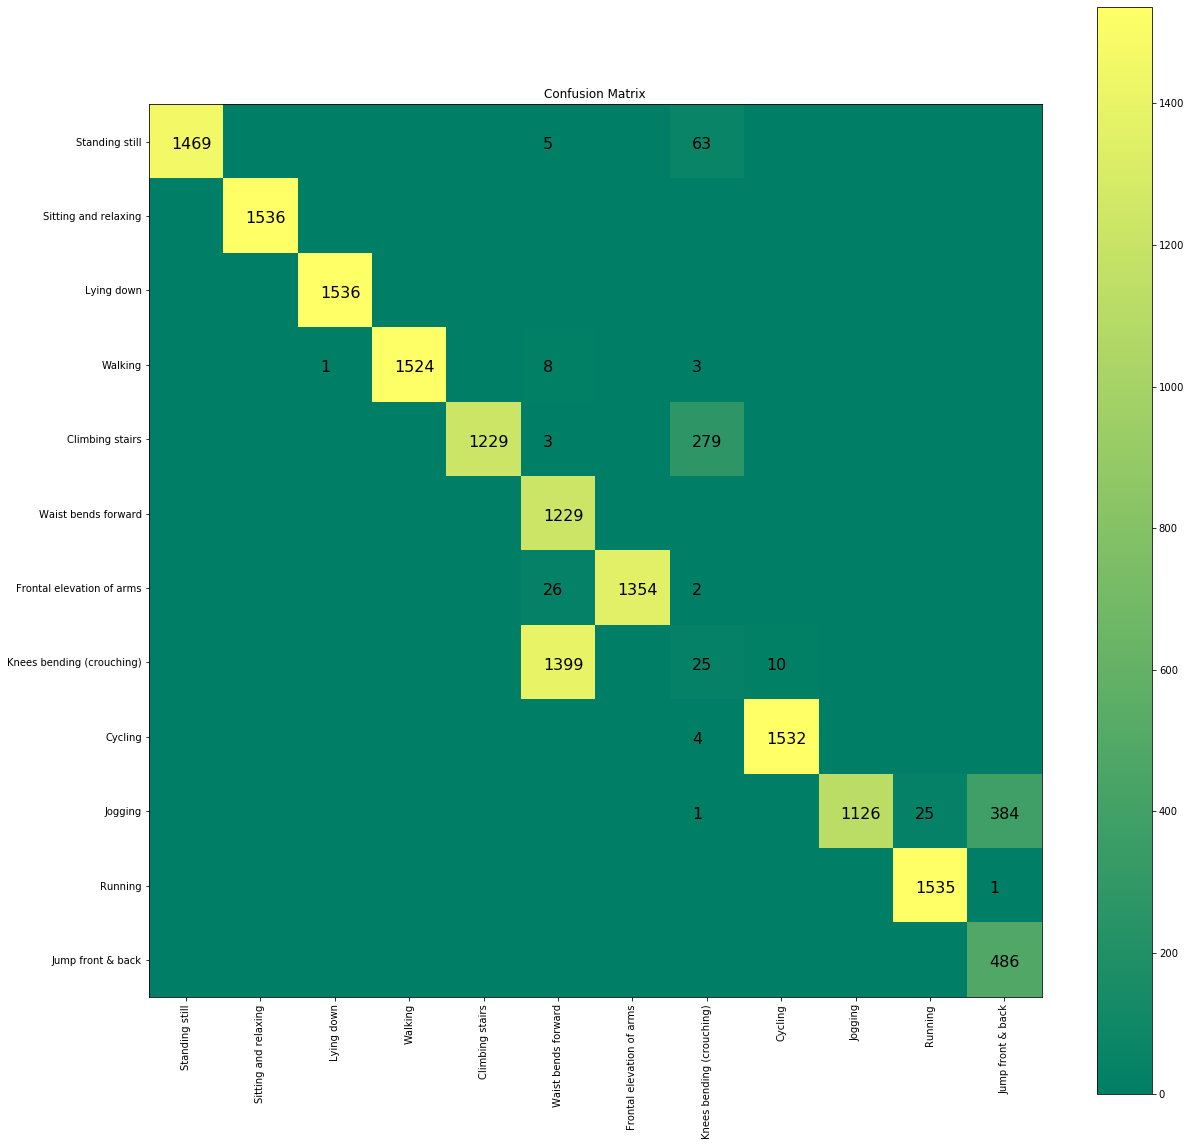

In [17]:
labels =['Standing still','Sitting and relaxing','Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
         'Cycling', 'Jogging', 'Running', 'Jump front & back']

fig = plt.figure(figsize=(20,20))
width = np.shape(conf_mat_test)[1]
height = np.shape(conf_mat_test)[0]

res = plt.imshow(np.array(conf_mat_test), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat_test):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(12), [l for l in labels], rotation=90)
_ = plt.yticks(range(12), [l for l in labels])

In [58]:
# evaluate the model using the test data set
_, accuracy = model_basic.evaluate(x_test, y_test_hot, batch_size=1, verbose=1)
accuracy

16795/16795 [==============================] - 21s 1ms/step


0.8598987793986306

In [59]:
# save the model
model_basic.save('basic_model.h5')

In [15]:
# import the saved model and re-evaluate
from tensorflow.keras.models import load_model
basic_model = load_model('basic_model.h5')
_, accuracy = basic_model.evaluate(x_test, y_test_hot, batch_size=1, verbose=1)
accuracy

16795/16795 [==============================] - 19s 1ms/step


0.8681750520988389

              precision    recall  f1-score   support

         1.0       1.00      0.96      0.98      1537
         2.0       1.00      1.00      1.00      1536
         3.0       1.00      1.00      1.00      1536
         4.0       1.00      0.99      1.00      1536
         5.0       1.00      0.81      0.90      1511
         6.0       0.46      1.00      0.63      1229
         7.0       1.00      0.98      0.99      1382
         8.0       0.07      0.02      0.03      1434
         9.0       0.99      1.00      1.00      1536
        10.0       1.00      0.73      0.85      1536
        11.0       0.98      1.00      0.99      1536
        12.0       0.56      1.00      0.72       486

    accuracy                           0.87     16795
   macro avg       0.84      0.87      0.84     16795
weighted avg       0.87      0.87      0.85     16795

[[1469    0    0    0    0    5    0   63    0    0    0    0]
 [   0 1536    0    0    0    0    0    0    0    0    0    0]
 [   0 

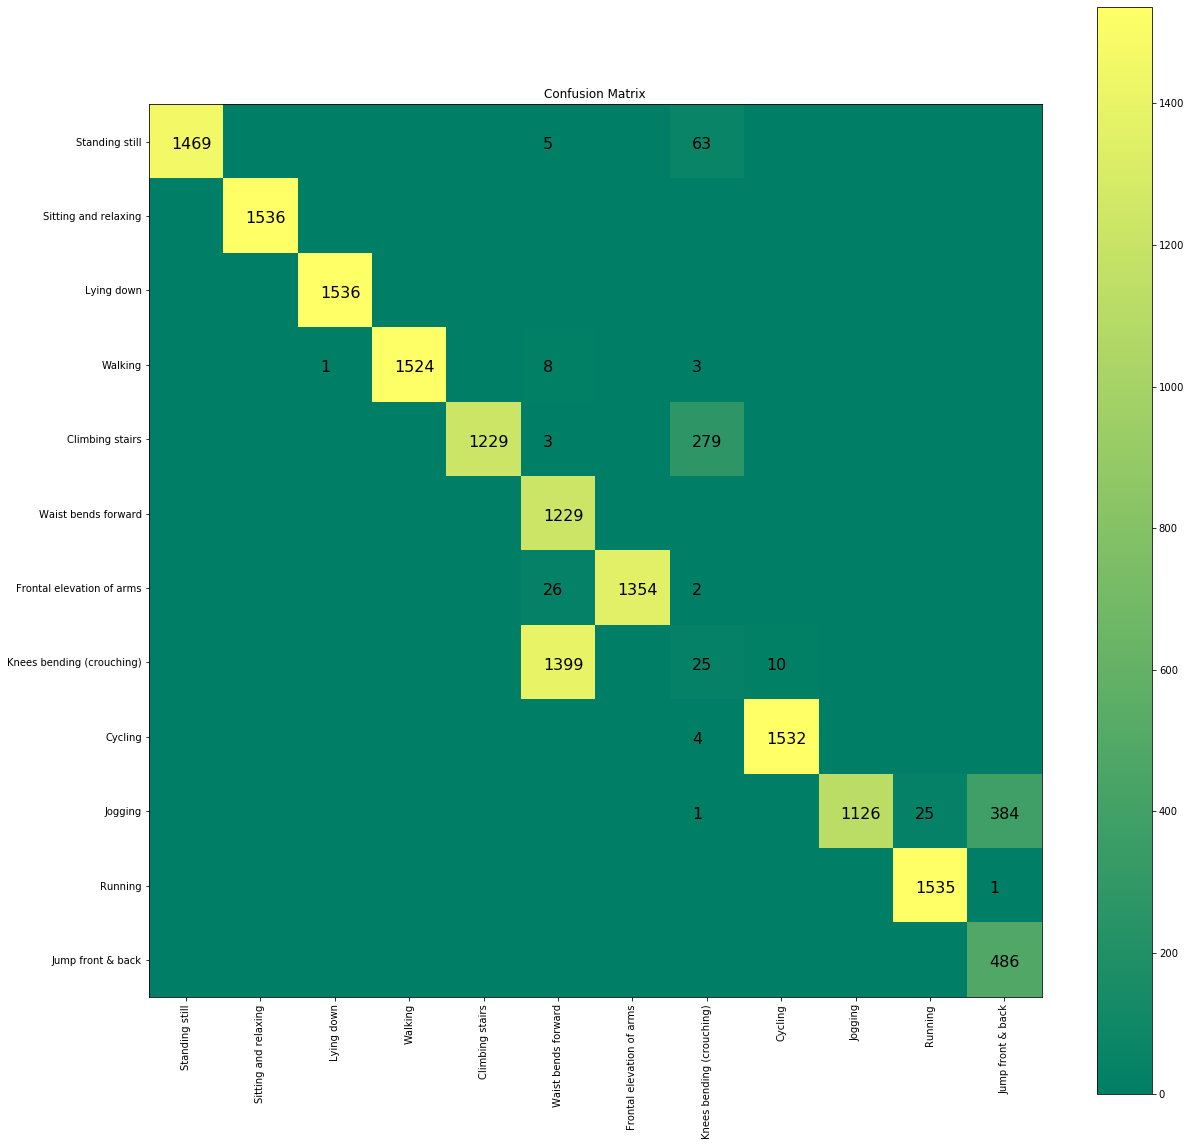

In [18]:
# get the classification report and confusion matrix for test data
y_pred_test = basic_model.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)+1
class_report_test = classification_report(y_test, max_y_pred_test)
conf_mat_test = confusion_matrix(y_test, max_y_pred_test)
print(class_report_test)
print(conf_mat_test)

labels =['Standing still','Sitting and relaxing','Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
         'Cycling', 'Jogging', 'Running', 'Jump front & back']

fig = plt.figure(figsize=(20,20))
width = np.shape(conf_mat_test)[1]
height = np.shape(conf_mat_test)[0]

res = plt.imshow(np.array(conf_mat_test), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat_test):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(12), [l for l in labels], rotation=90)
_ = plt.yticks(range(12), [l for l in labels])